This notebook generates measurement data with noise for orbit determination purposes, using a Keplerian propagator:

* Position/Velocity
* Range as seen from a list of ground stations
* Range rate (doppler) as seen from a list of ground stations
* Az/el as seen from a list of ground stations

The list of (example, not real) ground stations is loaded from the CSV file `ground-stations.csv`

This notebook is thought for small satellite operators wishing to perform orbit determination shortly after launch. Therefore the orbit parameters are defined by the state vector at spacecraft separation. 

The frame is usually defined by freezing the Earth inertial frame at launcher lift-off.

In [1]:
import numpy as np
import datetime
launch_date = datetime.datetime(2020, 1, 1)
separation_time = 3600.0  # seconds after lift-off
pos_init = [-3092.1e3, 1568.9e3, -5975.1e3] # Defined in frame frozen at lift-off time
vel_init = [-4767.1, 4630.9, 3671.0]

duration = 86400.0  # Duration of generated data, from separation date

Measurement parameters. For each type of measurement, two files are generated, one with the perfect measurements, one with noise added.
The noise for each type of measurement is modeled by a gaussian distribution with standard deviation $\sigma$

In [2]:
ground_stations_file = 'ground-stations.csv'
output_measurements_folder = 'generated-measurements'

sigma_position = 1000.0  # Position noise in meters
sigma_velocity = 1.0  # Velocity noise in meters per second
step_pv = 60.0  # Step time for output PV data

sigma_range = 100.0  # Range noise in meters
sigma_range_rate = 10.0  # Range rate noise in meters per second
sigma_az = float(np.deg2rad(0.5))  # Azimuth noise in radians
sigma_el = float(np.deg2rad(0.5))  # Elevation noise in radians
sigma_ra = float(np.deg2rad(0.5))  # Right ascension noise in radians
sigma_dec = float(np.deg2rad(0.5))  # Declination noise in radians
step_ground_station_measurements = 30.0  # When a ground station is in view, take measurements every 30 seconds

Loading the ground stations

In [3]:
import pandas as pd
ground_station_df = pd.read_csv(ground_stations_file, index_col=0)
display(ground_station_df)

,longitude_deg,latitude_deg,altitude
name,,,
Svalbard,15.0,78.0,0.0
Australia,117.0,-32.0,0.0
Argentina,-65.0,-35.0,0.0
Antarctica,-75.0,-73.0,0.0


Firing up a JVM for Orekit

In [4]:
import orekit
orekit.initVM()

Downloading and importing the Orekit data ZIP

In [5]:
from orekit.pyhelpers import download_orekit_data_curdir, setup_orekit_curdir
try:
    download_orekit_data_curdir()
except:
    print('Download failed')
setup_orekit_curdir()

Setting up models (frames, timescales)

In [6]:
from org.orekit.frames import FramesFactory
eme2000 = FramesFactory.getEME2000()
eci = eme2000  # Selecting EME2000 as Earth-centered inertial reference frame

from org.orekit.utils import IERSConventions
itrf = FramesFactory.getITRF(IERSConventions.IERS_2010, False)

from orekit.pyhelpers import datetime_to_absolutedate
lift_off_frame = itrf.getFrozenFrame(eci, 
                                     datetime_to_absolutedate(launch_date), 
                                     "Frame frozen at liftoff")

from org.orekit.models.earth import ReferenceEllipsoid
wgs84_ellipsoid = ReferenceEllipsoid.getWgs84(itrf)

from org.orekit.time import TimeScalesFactory
utc = TimeScalesFactory.getUTC()

Setting up initial orbit and propagator

In [7]:
from org.orekit.orbits import KeplerianOrbit
from org.orekit.utils import Constants as orekit_constants
separation_date = datetime_to_absolutedate(launch_date).shiftedBy(separation_time)

from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.utils import TimeStampedPVCoordinates
pv_init_lift_off_frame = TimeStampedPVCoordinates(separation_date, Vector3D(pos_init), Vector3D(vel_init))

# Transforming PV coordinates from lift-off frame to ECI frame
lift_off_frame_to_eci = lift_off_frame.getTransformTo(eci, datetime_to_absolutedate(launch_date))
pv_init_eci = lift_off_frame_to_eci.transformPVCoordinates(pv_init_lift_off_frame)

from org.orekit.orbits import CartesianOrbit
orbit = CartesianOrbit(pv_init_eci, eci, orekit_constants.EIGEN5C_EARTH_MU)

from org.orekit.propagation.analytical import KeplerianPropagator
propagator = KeplerianPropagator(orbit)

Orekit can generate measurements for all types of measurements that are used for OD. 

First, creating noise sources as Gaussian distribution.

In [8]:
from org.hipparchus.random import JDKRandomGenerator, GaussianRandomGenerator, CorrelatedRandomVectorGenerator
from org.hipparchus.linear import DiagonalMatrix

gaussian_random_generator = GaussianRandomGenerator(JDKRandomGenerator())

# Noise generator for range
noise_source_range = CorrelatedRandomVectorGenerator(
    DiagonalMatrix([sigma_range**2]),
    1e-6,  # "small" parameter
    gaussian_random_generator
)

# Noise generator for range rate
noise_source_range_rate = CorrelatedRandomVectorGenerator(
    DiagonalMatrix([sigma_range_rate**2]),
    1e-6,  # "small" parameter
    gaussian_random_generator
)

# Noise generator for AZ/EL
noise_source_az_el = CorrelatedRandomVectorGenerator(
    DiagonalMatrix([sigma_az**2, sigma_el**2]),
    1e-6,  # "small" parameter
    gaussian_random_generator
)

# Noise generator for RA/DEC
noise_source_ra_dec = CorrelatedRandomVectorGenerator(
    DiagonalMatrix([sigma_ra**2, sigma_dec**2]),
    1e-6,  # "small" parameter
    gaussian_random_generator
)

# Noise generator for PV
noise_source_pv = CorrelatedRandomVectorGenerator(
    DiagonalMatrix([sigma_position**2, sigma_position**2, sigma_position**2, 
                    sigma_velocity**2, sigma_velocity**2, sigma_velocity**2]),
    1e-6,  # "small" parameter
    gaussian_random_generator
)

Creating a measurement generator and adding a scheduler for each ground station and for each type of measurement.

There are two measurement generators used here, created with a loop: one with noise, the other one without noise.

In [9]:
from org.orekit.bodies import GeodeticPoint
from org.orekit.frames import TopocentricFrame
from org.orekit.propagation.events import ElevationDetector
from org.orekit.estimation.measurements import GroundStation
from org.orekit.estimation.measurements.generation import PVBuilder, RangeBuilder, RangeRateBuilder, AngularAzElBuilder, AngularRaDecBuilder, EventBasedScheduler, SignSemantic, Generator, ContinuousScheduler
from org.orekit.time import FixedStepSelector
from org.orekit.estimation.measurements import ObservableSatellite
from org.orekit.propagation.events.handlers import ContinueOnEvent

# Builder for PV measurements
observable_satellite = ObservableSatellite(0)

meas_generator_df = pd.DataFrame(
    {
        'noise_source_pv': [noise_source_pv, None],
        'noise_source_range': [noise_source_range, None],
        'noise_source_range_rate': [noise_source_range_rate, None],
        'noise_source_az_el': [noise_source_az_el, None],
        'noise_source_ra_dec': [noise_source_ra_dec, None]
    },
    index=['with_noise', 'without_noise']
)

for noise_type, noise_sources in meas_generator_df.iterrows():
    
    meas_generator = Generator()
    meas_generator.addPropagator(propagator)

    # Add PV builder
    meas_generator.addScheduler(
        ContinuousScheduler(
            PVBuilder(noise_sources['noise_source_pv'],
                      sigma_position,
                      sigma_velocity,
                      1.0,  # Base weight
                      observable_satellite), 
            FixedStepSelector(step_pv, utc))
    )

    for gs_name, gs_data in ground_station_df.iterrows():
        geodetic_point = GeodeticPoint(float(np.deg2rad(gs_data['latitude_deg'])),
                                       float(np.deg2rad(gs_data['longitude_deg'])),
                                       float(gs_data['altitude']))
        topocentric_frame = TopocentricFrame(wgs84_ellipsoid, geodetic_point, gs_name)
        ground_station_df.loc[gs_name, 'GroundStation'] = GroundStation(topocentric_frame)

        # Range builder
        meas_generator.addScheduler(
            EventBasedScheduler(
                RangeBuilder(noise_sources['noise_source_range'], 
                             GroundStation(topocentric_frame), 
                             True,  # two-way
                             sigma_range, 
                             1.0,  # Base weight
                             observable_satellite), 
                FixedStepSelector(step_ground_station_measurements, utc), 
                propagator, 
                ElevationDetector(topocentric_frame).withHandler(ContinueOnEvent()), 
                SignSemantic.FEASIBLE_MEASUREMENT_WHEN_POSITIVE)
        )

        # Range rate builder
        meas_generator.addScheduler(
            EventBasedScheduler(
                RangeRateBuilder(noise_sources['noise_source_range_rate'],
                                 GroundStation(topocentric_frame), 
                                 True,  # two-way
                                 sigma_range_rate, 
                                 1.0,  # Base weight
                                 observable_satellite), 
                FixedStepSelector(step_ground_station_measurements, utc), 
                propagator, 
                ElevationDetector(topocentric_frame).withHandler(ContinueOnEvent()), 
                SignSemantic.FEASIBLE_MEASUREMENT_WHEN_POSITIVE)
        )

        # Az/el builder
        meas_generator.addScheduler(
            EventBasedScheduler(
                AngularAzElBuilder(noise_sources['noise_source_az_el'], 
                                   GroundStation(topocentric_frame),
                                   [sigma_az, sigma_el], 
                                   [1.0, 1.0],  # Base weight
                                   observable_satellite), 
                FixedStepSelector(step_ground_station_measurements, utc), 
                propagator, 
                ElevationDetector(topocentric_frame).withHandler(ContinueOnEvent()), 
                SignSemantic.FEASIBLE_MEASUREMENT_WHEN_POSITIVE)
        )

        # RA/DEC builder
        meas_generator.addScheduler(
            EventBasedScheduler(
                AngularRaDecBuilder(noise_sources['noise_source_ra_dec'], 
                                   GroundStation(topocentric_frame),
                                   eci,  # RA/DEC measurements are defined in Earth-centered inertial frame
                                   [sigma_ra, sigma_dec], 
                                   [1.0, 1.0],  # Base weight
                                   observable_satellite), 
                FixedStepSelector(step_ground_station_measurements, utc), 
                propagator, 
                ElevationDetector(topocentric_frame).withHandler(ContinueOnEvent()), 
                SignSemantic.FEASIBLE_MEASUREMENT_WHEN_POSITIVE)
        )
        
    meas_generator_df.loc[noise_type, 'meas_generator'] = meas_generator

Propagating, retrieving the generated measurements, and saving them to CSV files.

Warning: the cell below cannot be run a second time without running the cell above again before. Otherwise the result structure will be empty.

In [10]:
from orekit.pyhelpers import absolutedate_to_datetime
from org.orekit.estimation.measurements import ObservedMeasurement, PV, Range, RangeRate, AngularAzEl, AngularRaDec
import os

date_start = separation_date
date_end = date_start.shiftedBy(duration)
date_current = date_start

for noise_type, noise_sources in meas_generator_df.iterrows():
    generated = noise_sources['meas_generator'].generate(date_start, date_end)
    pv_df = pd.DataFrame(columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
    range_df = pd.DataFrame(columns=['ground_station', 'range'])
    range_rate_df = pd.DataFrame(columns=['ground_station', 'range_rate'])
    az_el_df = pd.DataFrame(columns=['ground_station', 'az_deg', 'el_deg'])
    ra_dec_df = pd.DataFrame(columns=['ground_station', 'ra_deg', 'dec_deg'])

    for meas in generated.toArray():
        observed_meas = ObservedMeasurement.cast_(meas)
        py_datetime = absolutedate_to_datetime(observed_meas.date)

        if PV.instance_(observed_meas):
            observed_pv = PV.cast_(observed_meas)
            pv_df.loc[py_datetime] = np.array(observed_meas.getObservedValue())
            
        elif Range.instance_(observed_meas):
            observed_range = Range.cast_(observed_meas)
            range_df.loc[py_datetime] = np.concatenate(([observed_range.getStation().getBaseFrame().name], 
                                                        np.array(observed_range.getObservedValue())))
            
        elif RangeRate.instance_(observed_meas):
            observed_range_rate = RangeRate.cast_(observed_meas)
            range_rate_df.loc[py_datetime] = np.concatenate(([observed_range_rate.getStation().getBaseFrame().name], 
                                                             np.array(observed_range_rate.getObservedValue())))
            
        elif AngularAzEl.instance_(observed_meas):
            observed_az_el = AngularAzEl.cast_(observed_meas)
            az_el_df.loc[py_datetime] = np.concatenate(([observed_az_el.getStation().getBaseFrame().name], 
                                                        np.rad2deg(observed_az_el.getObservedValue())))
        elif AngularRaDec.instance_(observed_meas):
            observed_ra_dec = AngularRaDec.cast_(observed_meas)
            ra_dec_df.loc[py_datetime] = np.concatenate(([observed_ra_dec.getStation().getBaseFrame().name], 
                                                         np.rad2deg(observed_ra_dec.getObservedValue())))
            
    pv_df.index.name = 'datetime_utc'
    pv_df.to_csv(os.path.join(output_measurements_folder, f'pv_simulated_{eci.getName().lower()}_{noise_type}.csv'))
            
    range_df.index.name = 'datetime_utc'
    range_df.to_csv(os.path.join(output_measurements_folder, f'range_simulated_{noise_type}.csv'))
            
    range_rate_df.index.name = 'datetime_utc'
    range_rate_df.to_csv(os.path.join(output_measurements_folder, f'range_rate_simulated_{noise_type}.csv'))
            
    az_el_df.index.name = 'datetime_utc'
    az_el_df.to_csv(os.path.join(output_measurements_folder, f'az_el_simulated_{noise_type}.csv'))
            
    ra_dec_df.index.name = 'datetime_utc'
    ra_dec_df.to_csv(os.path.join(output_measurements_folder, f'ra_dec_simulated_{eci.getName().lower()}_{noise_type}.csv'))

Propagating the orbit again to plot the ground track

In [11]:
from org.orekit.propagation.sampling import PythonOrekitFixedStepHandler
from orekit.pyhelpers import absolutedate_to_datetime
from org.orekit.utils import IERSConventions
from org.orekit.frames import FramesFactory
from org.orekit.models.earth import ReferenceEllipsoid
import numpy as np
import pandas as pd

class mystephandler(PythonOrekitFixedStepHandler):    
    itrf = FramesFactory.getITRF(IERSConventions.IERS_2010, False)  # Taking tidal effects into account when interpolating EOP parameters
    wgs84_ellipsoid = ReferenceEllipsoid.getWgs84(itrf)
    lat_lon_df = pd.DataFrame(columns=['lat_deg', 'lon_deg'])
    
    def init(self, s0, t, step):
        pass
        
    def handleStep(self, currentState, isLast):
        geodetic_point = wgs84_ellipsoid.transform(currentState.getPVCoordinates(self.itrf).getPosition(),
                                                   self.itrf,
                                                   currentState.getDate())
        self.lat_lon_df.loc[absolutedate_to_datetime(currentState.getDate())] = [np.rad2deg(geodetic_point.getLatitude()),
                                                                                 np.rad2deg(geodetic_point.getLongitude())]
        
    def getLatLon(self):
        return self.lat_lon_df
    
handler = mystephandler()
propagator = KeplerianPropagator(orbit)
propagator.setMasterMode(60.0, handler)
finalState = propagator.propagate(date_end)
lat_lon_df = handler.getLatLon()

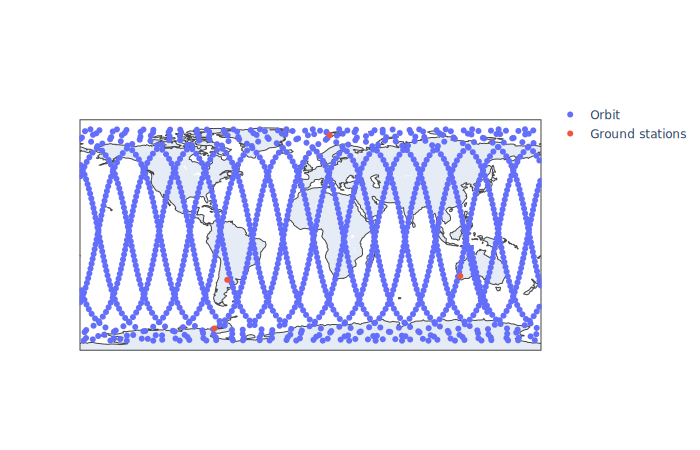

In [12]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Scattergeo(
        lon = lat_lon_df['lon_deg'],
        lat = lat_lon_df['lat_deg'],
        mode = 'markers',
        name='Orbit'
    ),
    go.Scattergeo(
        lon = ground_station_df['longitude_deg'],
        lat = ground_station_df['latitude_deg'],
        text = ground_station_df.index,
        mode = 'markers',
        name='Ground stations'
    )
])

fig.show(renderer='svg')